### Next sample strategy

Considered strategies used to propose the next problem:
1. Randomly sample from the dataset D. Does not model the student and is therefore unable to adapt to their ability. May present redundant teaching examples of concepts that have already been learned by the student and not reinforce concepts that the student has shown to be uncertain about.
2. ~~Worst predicted. Related to uncertainty sampling used in Active Learning. Selects the next teaching image whose prediction deviates most from the ground truth. Prone to proposing outliers. In the learning to program problem, maybe it presents the hardest exercises?~~
3. Expected Error Reduction. Chooses the teaching image which, if labeled correctly, would have the greatest reduction on the future error over the images that are not in the teaching set. Student’s conditional distribution given the teaching set can be approximated using Gaussian Random Field.

#### Import libraries

In [2]:
# Input
from db import PythonProblems
import io

# Helpers
import numpy as np

# Preprocessing
import tokenize
from sklearn.feature_extraction.text import CountVectorizer

# Distance
# from scipy.spatial.distance import pdist, squareform
from sklearn.metrics.pairwise import cosine_similarity

# Learning
from clustering import Clustering
from plot2d import Plot2D

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from generate_pdf import PDFReport

%matplotlib inline

In [3]:
db = PythonProblems('python.sqlite')

In [4]:
removed_itens = ['NEWLINE', 'STRING', 'ENDMARKER', 'NUMBER', 'INDENT', 'DEDENT', "NL", 'COMMENT', 'ERRORTOKEN']
allowed_itens = ['NAME', 'OP']
cursor = db.conn.cursor()
docs = []
docs_id = []
doc_category = []
errors = []
questions = []
solutions = []

# lendo os dados
cursor.execute("""
SELECT solution.id, solution.content, problem.content, problem.category FROM solution, problem where solution.problem_id = problem.id;
""")


for idx, row in enumerate(cursor.fetchall()):
    file = io.StringIO(row[1])
    doc = []
    try:
        for item in tokenize.generate_tokens(file.readline):
            if tokenize.tok_name[item[0]] not in removed_itens:
                if tokenize.tok_name[item[0]] in allowed_itens:
                    doc.append(item[1])
                else:
                    print("%s %s" % (tokenize.tok_name[item[0]], item[1]))
    except (IndentationError, tokenize.TokenError):
        errors.append("Please, fix solution %d before continuing" % (idx+1))
    
    if doc == []:
        continue
    docs.append(' '.join(doc))
    docs_id.append(row[0])
    doc_category.append(row[-1])
    questions.append(row[2])
    solutions.append(row[1])

print("Got %d documents" %(idx+1))

if not errors:
    print("Success in parsing all documents! You may go on!")
else:
    for item in errors:
        print(item)

Got 758 documents
Success in parsing all documents! You may go on!


***Limitação do parser: variável e nome reservado são do mesmo tipo. Não consigo separar sem fazer uma pré-lista. Mas pode ser o critério para ajustar o CountVectorizer***

### Preprocessing solutions into bag of words ###

In [37]:
# Initialize the "CountVectorizer" object, which is scikit-learn's
# bag of words tool.  
vectorizer = CountVectorizer(analyzer = "word",   \
                             tokenizer = None,    \
                             preprocessor = None, \
#                              stop_words = ['print'],   \
                             #max_features = 26d,
                             binary=False,
                             min_df=0.1
                            ) 

# fit_transform() does two functions: First, it fits the model
# and learns the vocabulary; second, it transforms our training data
# into feature vectors. The input to fit_transform should be a list of 
# strings.

train_data_features = vectorizer.fit_transform(docs)

# Numpy arrays are easy to work with, so convert the result to an 
# array
# Document-term matrix
train_data_features = train_data_features.toarray()
train_data_features.shape

(753, 16)

In [38]:
# Remove rows containing only zeros (weird exercises)
solution_sample = train_data_features[~(train_data_features==0).all(1)]
docs_id = np.asarray(docs_id)[~(train_data_features==0).all(1)]
doc_category = np.asarray(doc_category)[~(train_data_features==0).all(1)]
questions = np.asarray(questions)[~(train_data_features==0).all(1)]
solution_sample.shape

IndexError: boolean index did not match indexed array along dimension 0; dimension is 750 but corresponding boolean dimension is 753

### Cluster solutions

In [7]:
%%time
cluster_names = ['', 'conditional', 'dict', 'file', 'function', 'list', 'loop'] #'math', 'string']
handler = Plot2D(clusters=cluster_names, doc_category=doc_category, doc_id=docs_id)
handler.seed = 1
handler.reduce(solution_sample)

CPU times: user 15.2 s, sys: 884 ms, total: 16.1 s
Wall time: 16 s


3403435803


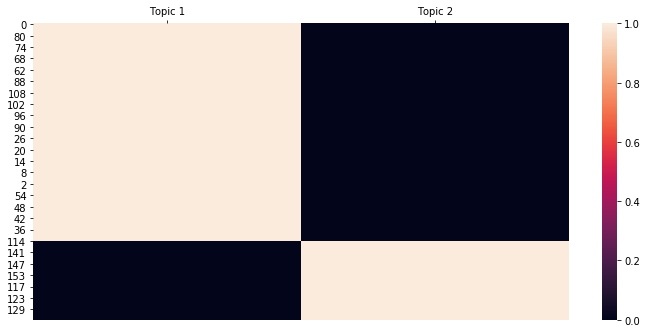

In [36]:
clustering = Clustering(handler.X, 2)
# clustering.seed = 4006033762
# clustering.seed = 0
clustering._generate_random_state()
model, document_topic, word_topic = clustering.gaussian_mixture()
print(clustering.seed)
clustering.plot_topic_distribution()

### Get next sample

Set initial matrices

In [15]:
# Create X as an empty belief state (X is the machine's model of the student's distribution)
X = np.zeros(clustering.document_topic.shape) # nS x nC
print(X.shape)

# Create Y as a document_topic matrix. For the first version, each document belongs to one topic
Y = clustering.document_topic # nS x nC
print(Y.shape)

# Create W as a similarity matrix
W = cosine_similarity(solution_sample) # nS x nS
print(W.shape)

# Set L as an unlabelled set
L = []

(750, 8)
(750, 8)
(750, 750)


#### Visualization
Reduce to 2 dimensions using TSNE

In [16]:
# %%time
# cluster_names = ['', 'conditional', 'dict', 'file', 'function', 'list', 'loop'] #'math', 'string']
# handler = Plot2D(clusters=cluster_names, doc_category=doc_category, doc_id=docs_id)
# handler.seed = 1
# handler.reduce(solution_sample)

#### Get next question

Question 0
Question 1
Question 2
Question 3
Question 4
Question 5
Question 6
Question 7
Question 8
Question 9


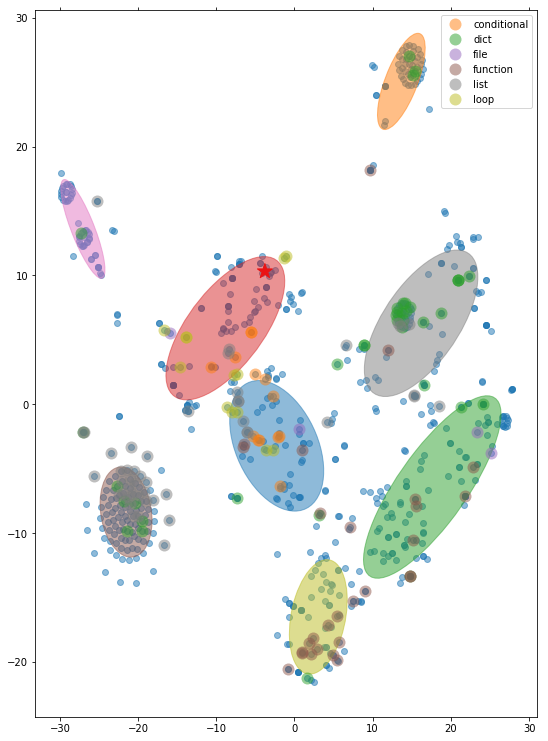

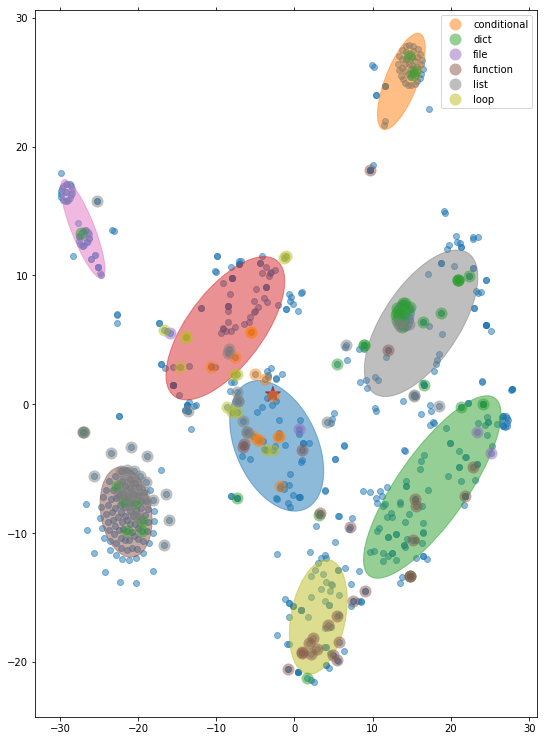

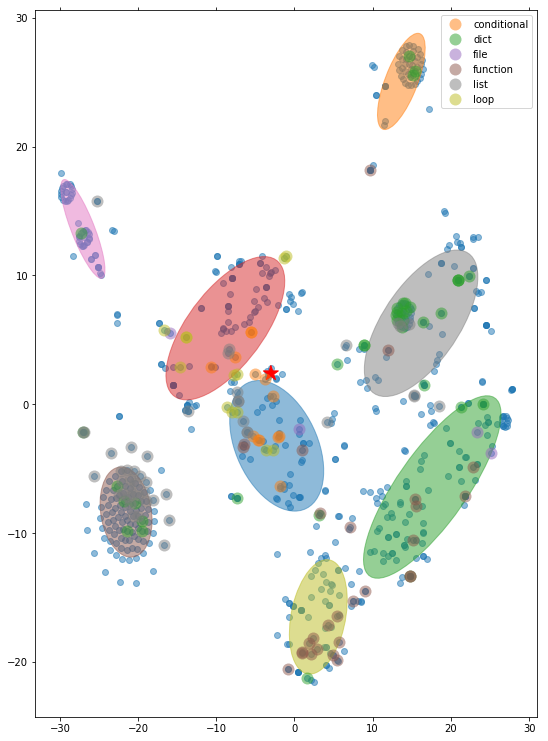

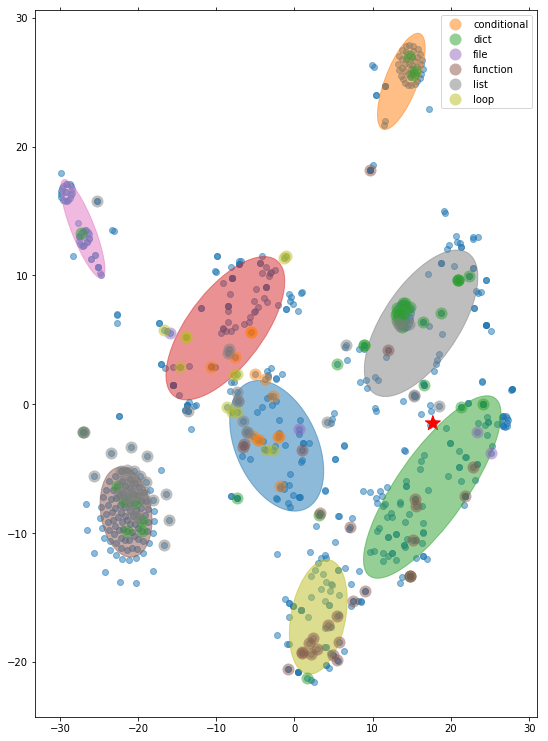

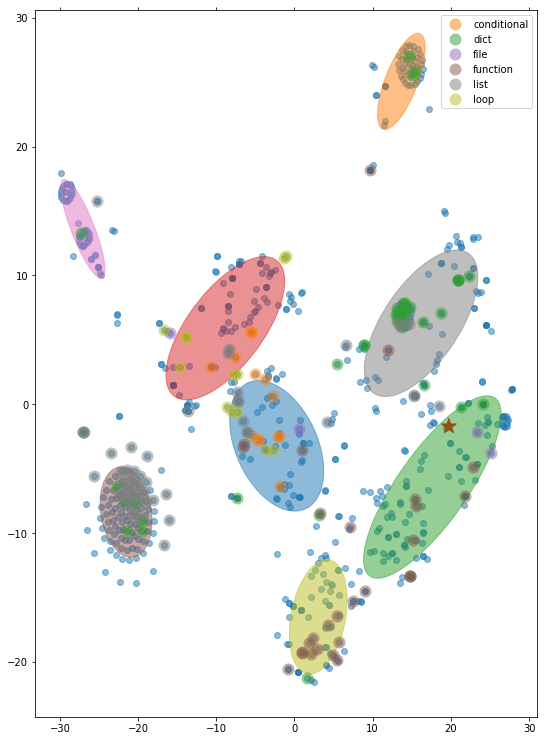

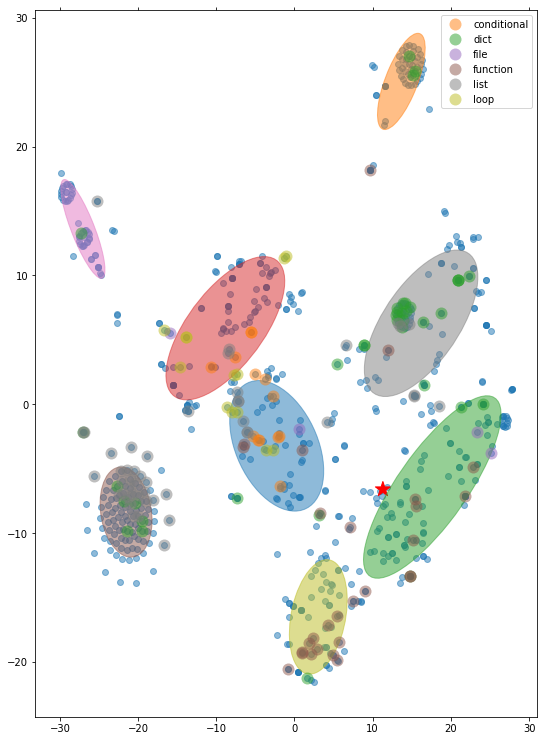

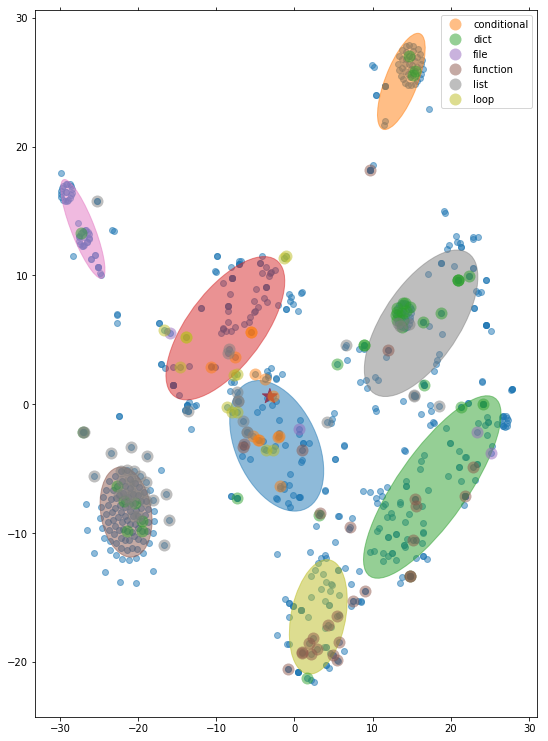

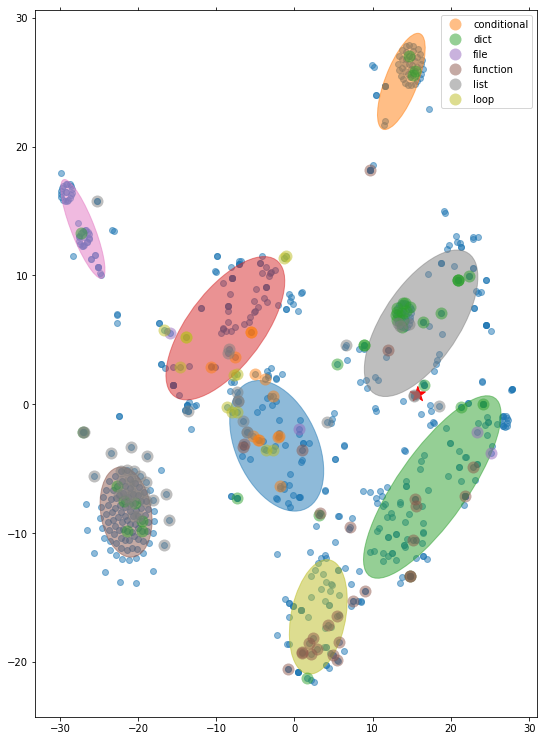

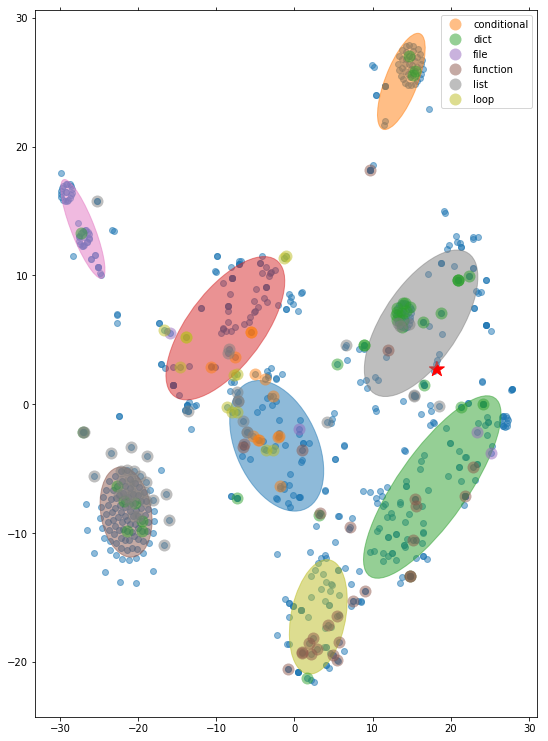

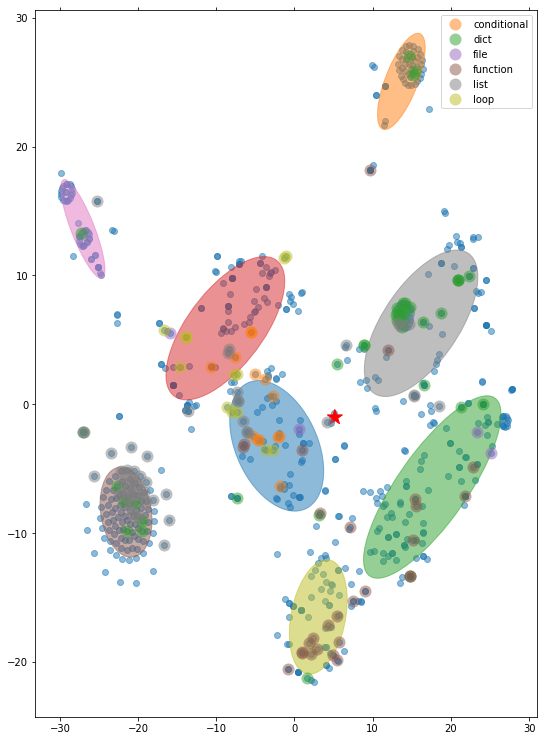

In [17]:
# doc = PDFReport()
for i in range(10):
    # Plot sample
    sample_id, uRisks = get_next_sample(X, Y, W, L)
    ellipses_opt = {"gmm": clustering.model, "clusters": clustering.k}
    handler.plot(show_clusters=True, highlight=sample_id, show=False, savefig="solution_%d.png" % sample_id,
                make_ellipses=ellipses_opt)
    print("Question %d" % sample_id)
    
    # Print question
#     problem = questions[sample_id]
#     solution = solutions[sample_id]
    
    # Suppose that the student gets it correctly
    # Update X matrix
    X[sample_id] = Y[sample_id]
    L.append(sample_id)
#     doc.append_solution(sample_id, problem, solution)

# doc.generate_pdf("user_trajectory")

### Selecting observations

In [18]:
import pandas as pd

In [19]:
data = pd.DataFrame(clustering.X)

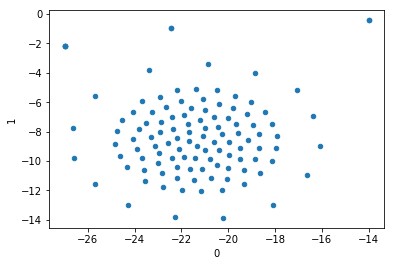

In [20]:
cluster1 = data[(data[0] < -14) & (data[1]<0)]
cluster1.plot.scatter(0,1)

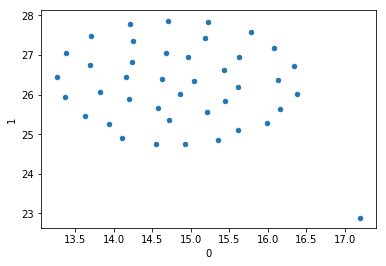

In [21]:
cluster2 = data[(data[0] > 12) & (data[1] > 20)]
cluster2.plot.scatter(0,1)

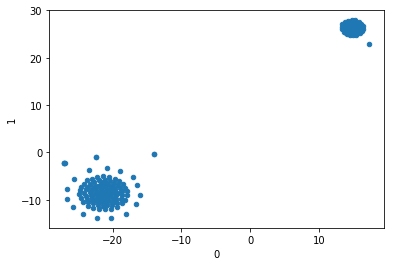

In [22]:
data_clean = pd.concat([cluster1, cluster2])
data_clean.plot.scatter(0,1)

1488881382


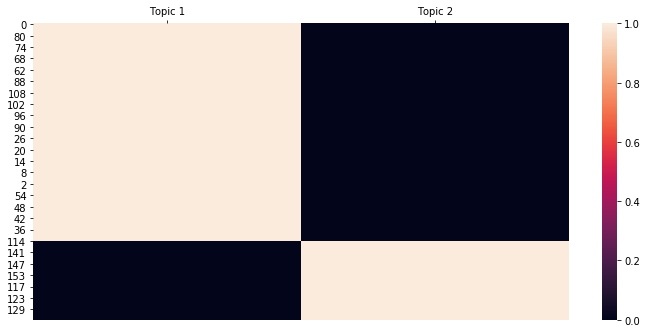

In [23]:
clustering = Clustering(data_clean, 2)
# clustering.seed = 4006033762
# clustering.seed = 0
clustering._generate_random_state()
model, document_topic, word_topic = clustering.gaussian_mixture()
print(clustering.seed)
clustering.plot_topic_distribution()

In [28]:
# Create X as an empty belief state (X is the machine's model of the student's distribution)
X = np.zeros(clustering.document_topic.shape) # nS x nC
print(X.shape)

# Create Y as a document_topic matrix. For the first version, each document belongs to one topic
Y = clustering.document_topic # nS x nC
print(Y.shape)

# Create W as a similarity matrix
W = cosine_similarity(clustering.X) # nS x nS
print(W.shape)

# Set L as an unlabelled set
L = []

(156, 2)
(156, 2)
(156, 156)


In [29]:
handler = Plot2D(clusters=cluster_names, doc_category=doc_category[clustering.X.index.tolist()],
                 doc_id=docs_id[clustering.X.index.tolist()])

In [30]:
handler.X = np.array(clustering.X)
handler.xs, handler.ys = np.array(clustering.X[0]), np.array(clustering.X[1])

Question 85
Question 121
Question 1
Question 138
Question 133
Question 2
Question 146
Question 110
Question 142
Question 123
Question 40
Question 119
Question 48
Question 122
Question 128
Question 46
Question 154
Question 64
Question 145
Question 35


/home/lmoraes/miniconda3/envs/machine_teaching/lib/python3.6/site-packages/matplotlib/pyplot.py:528: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Question 136
Question 149
Question 19
Question 126
Question 109


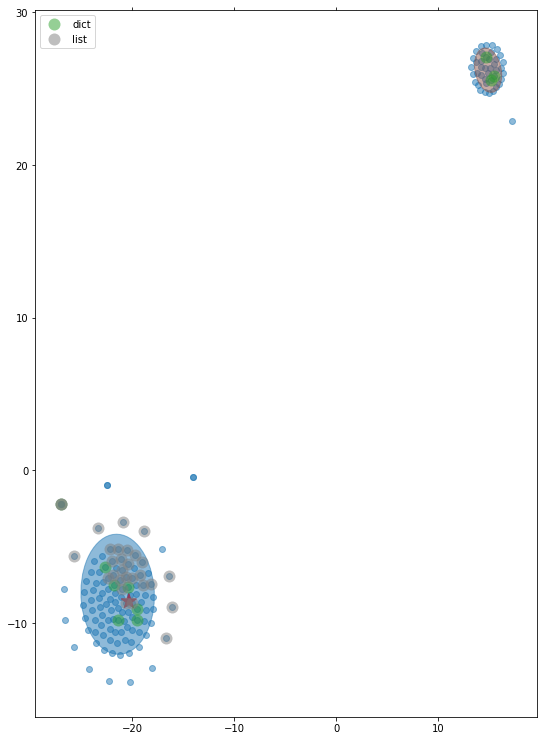

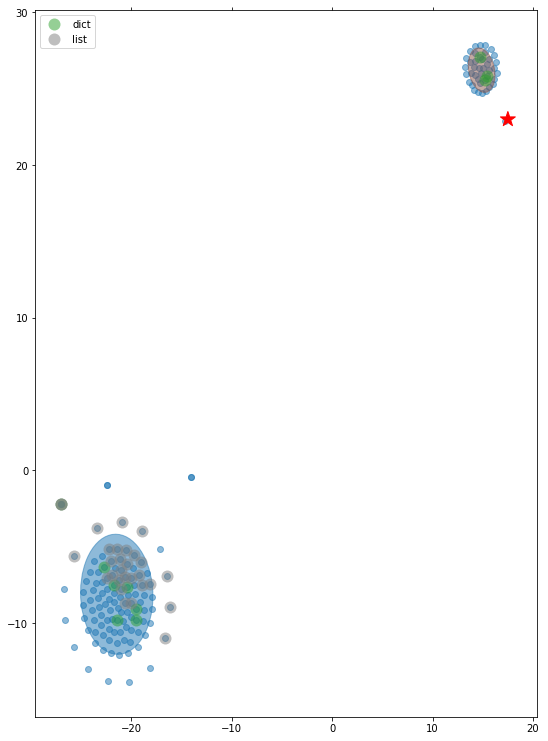

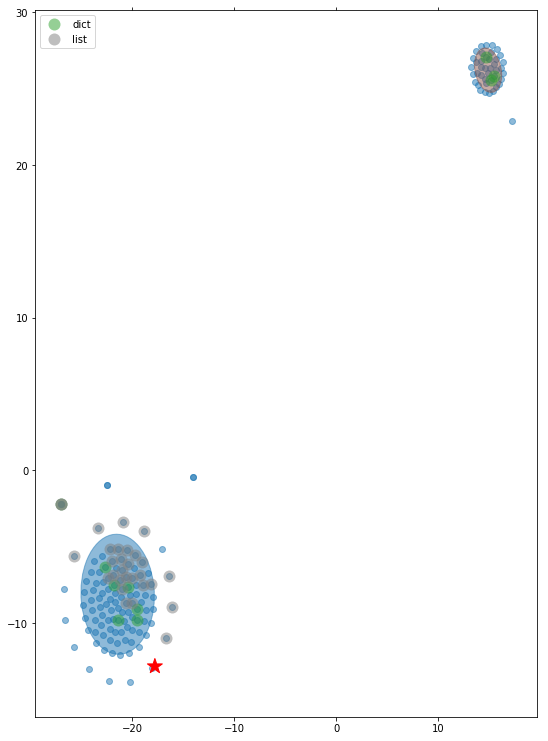

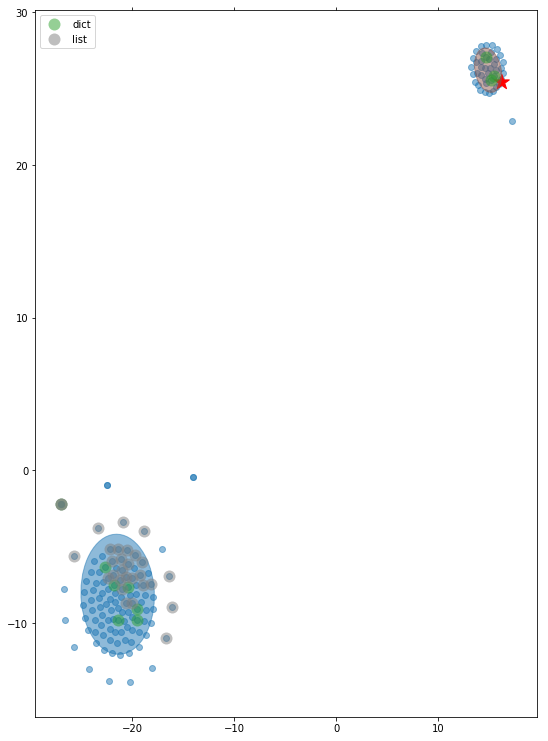

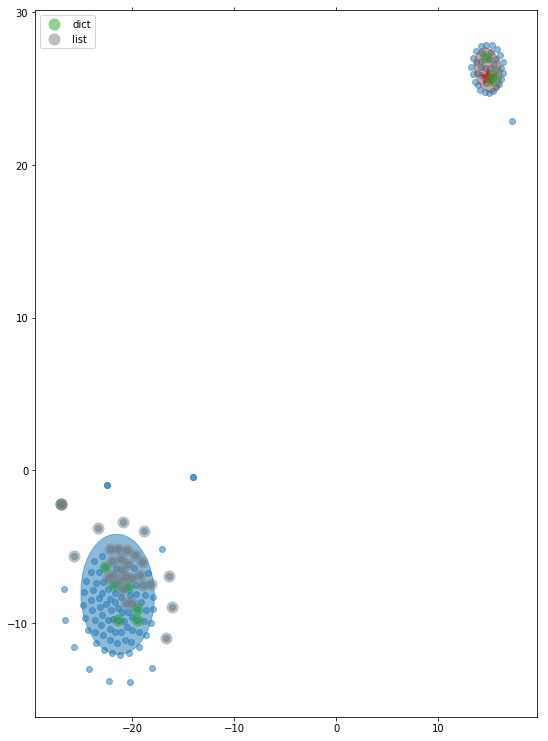

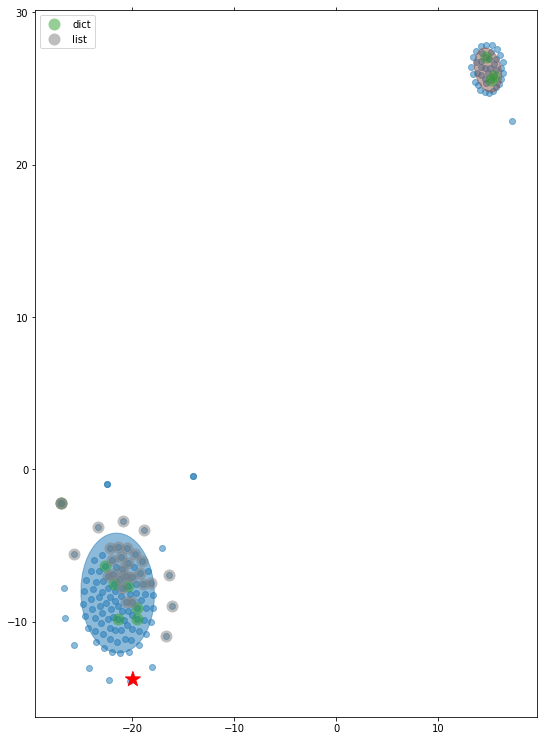

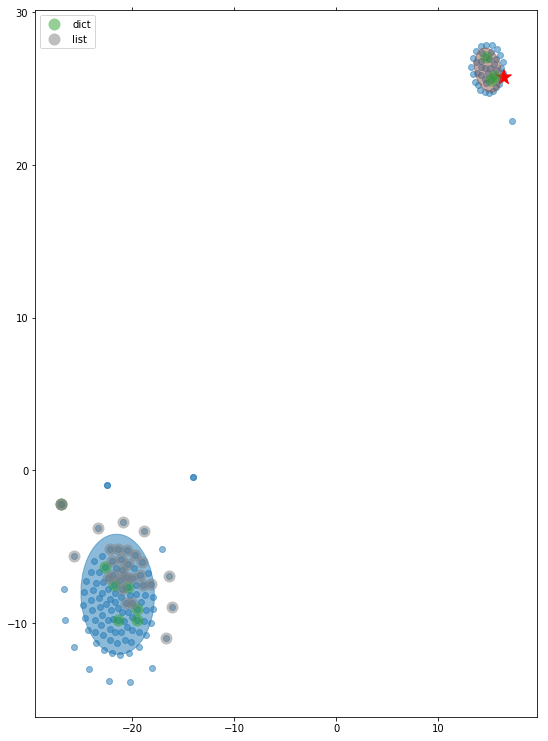

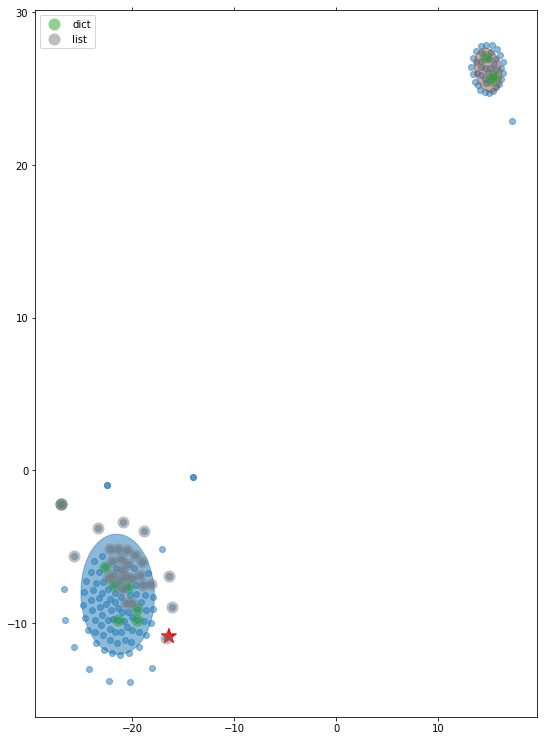

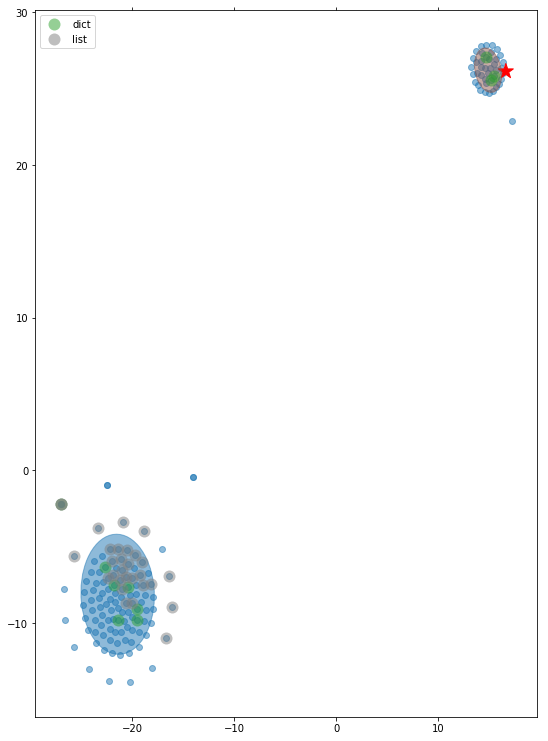

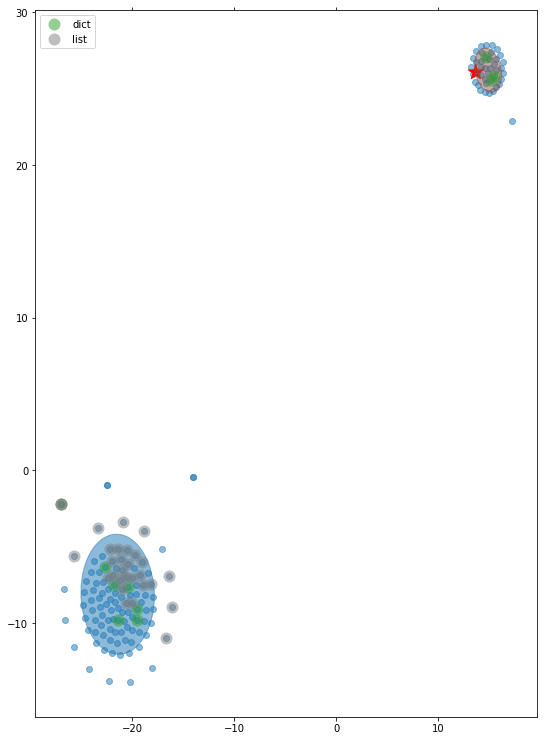

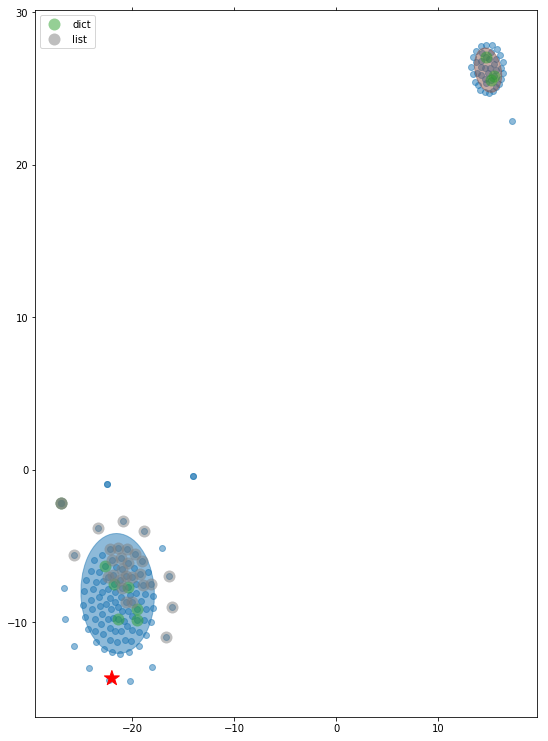

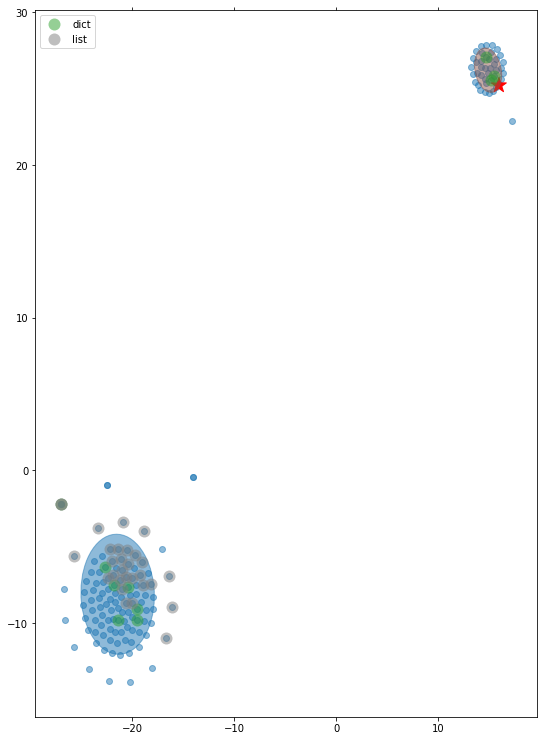

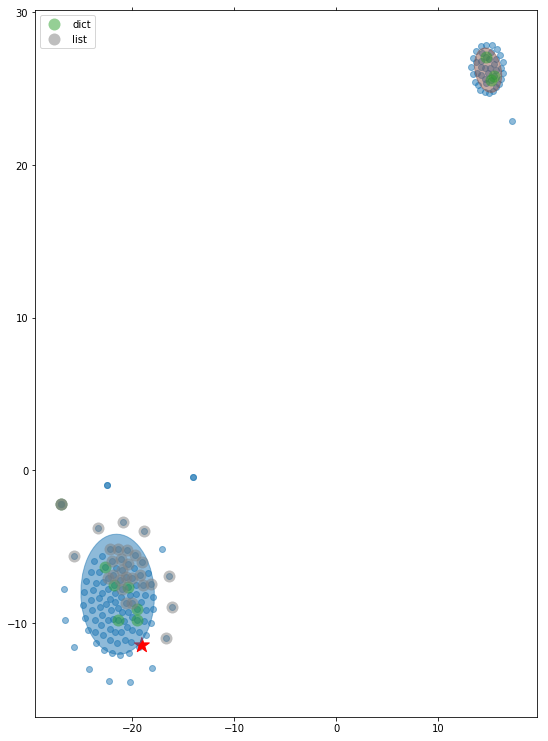

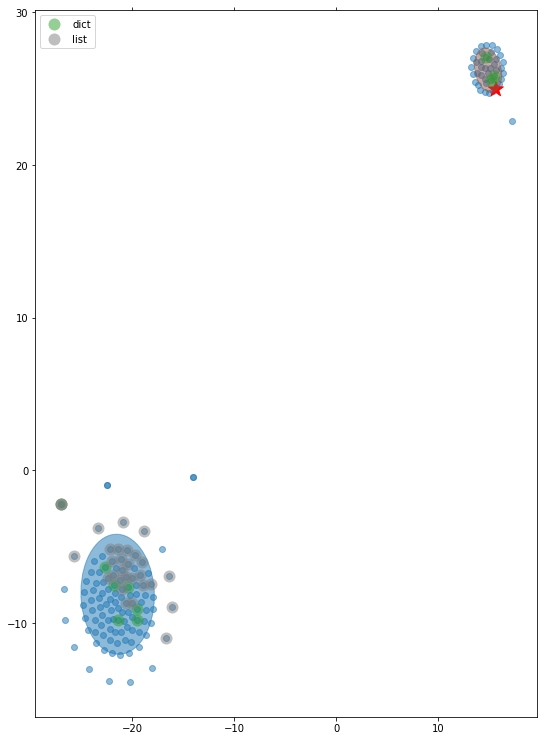

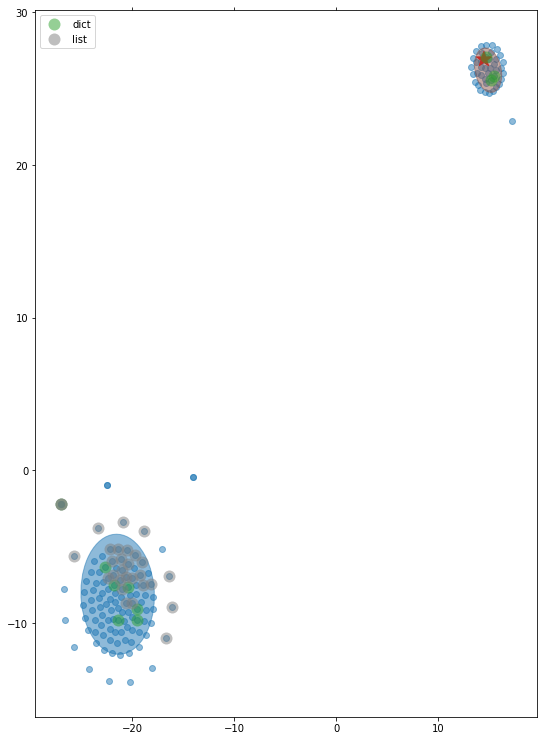

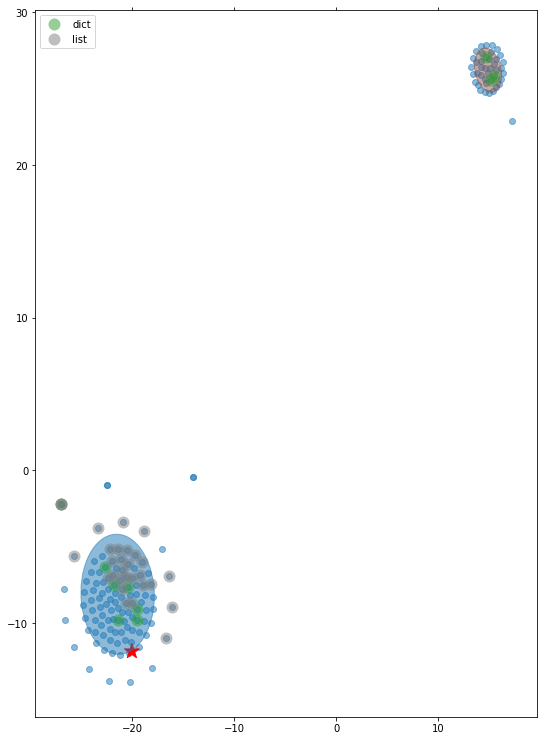

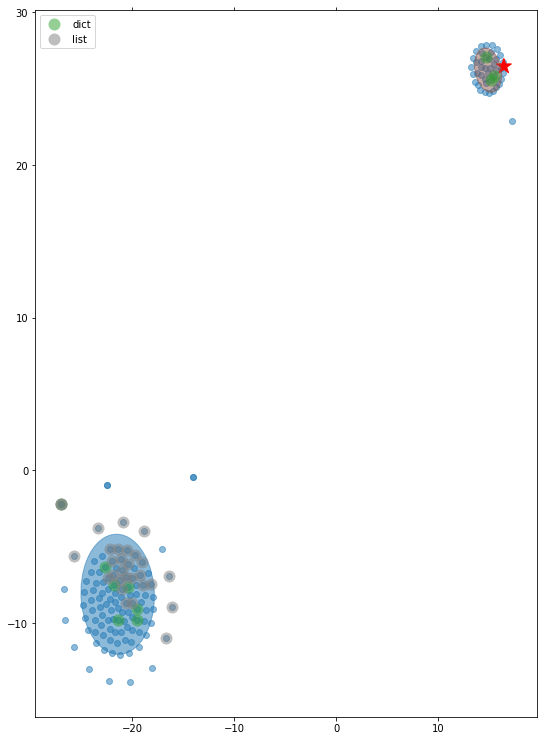

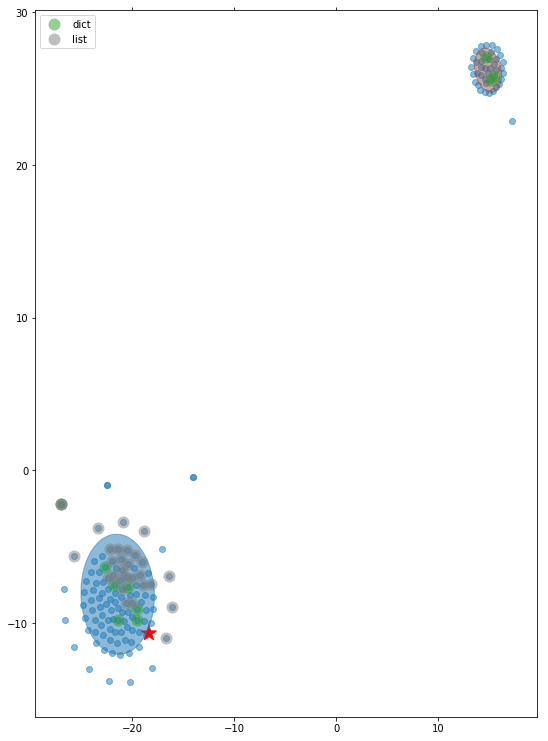

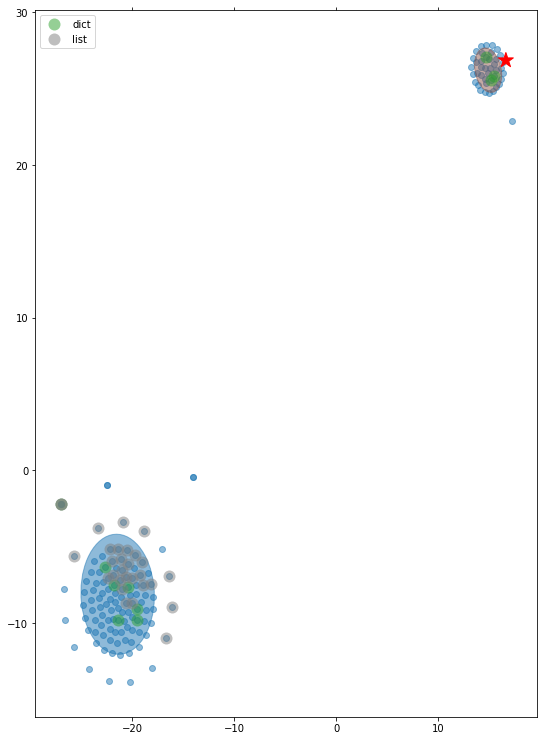

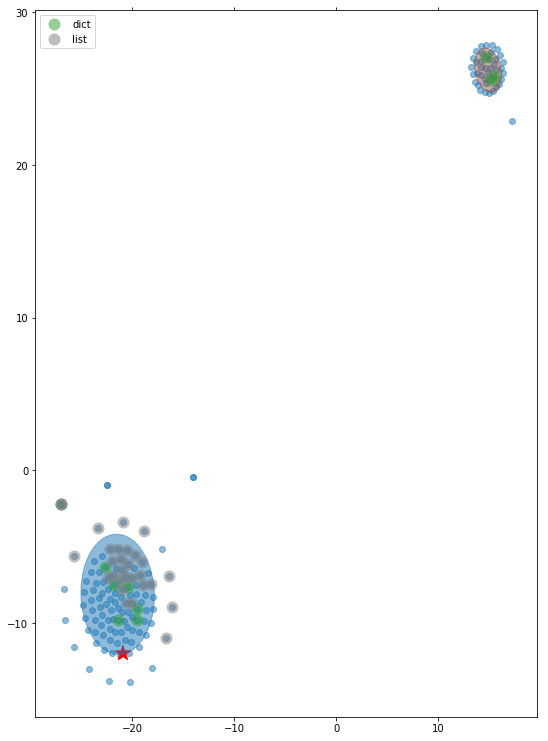

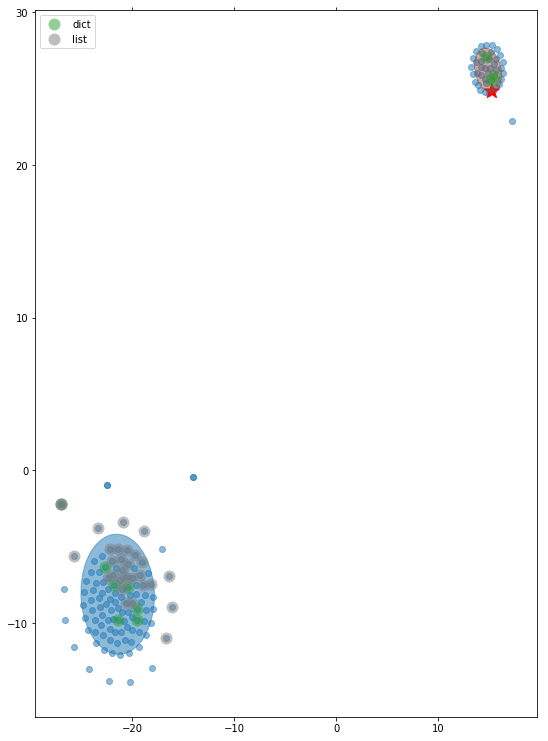

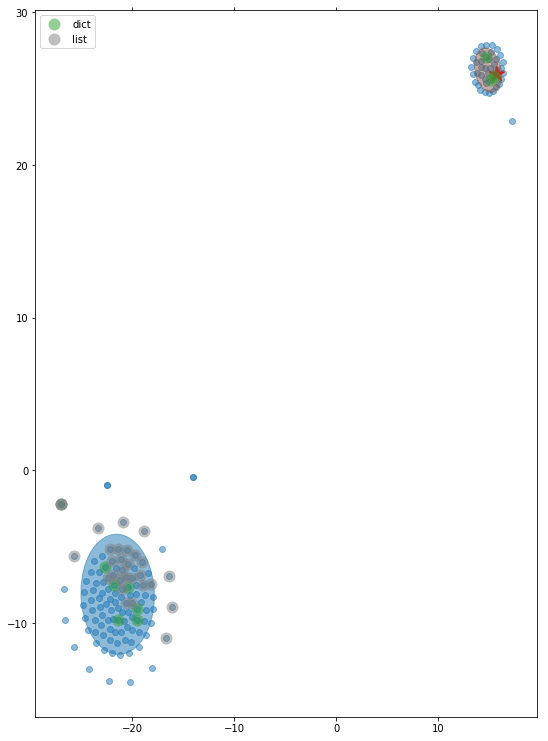

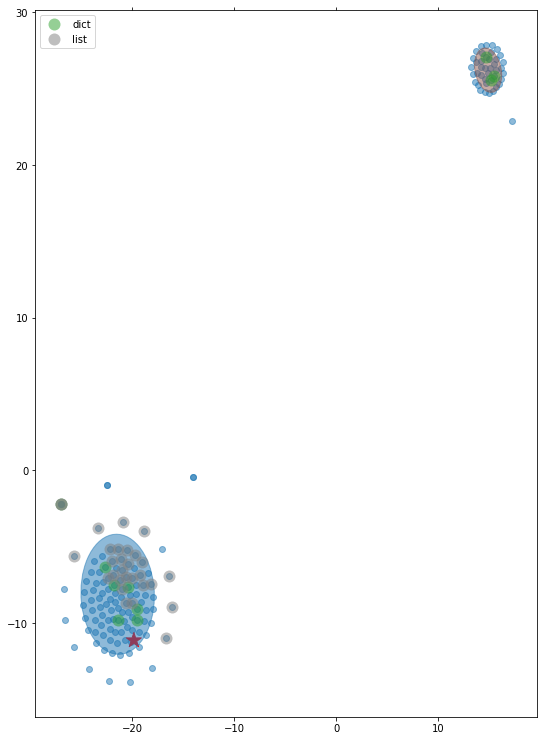

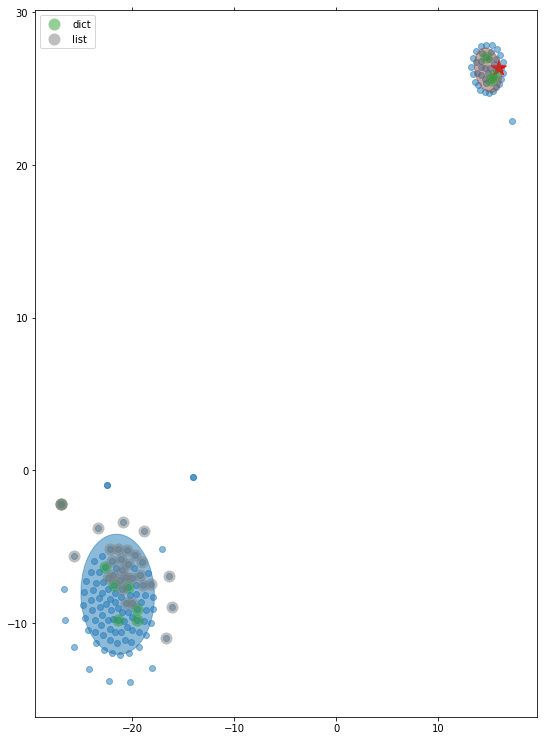

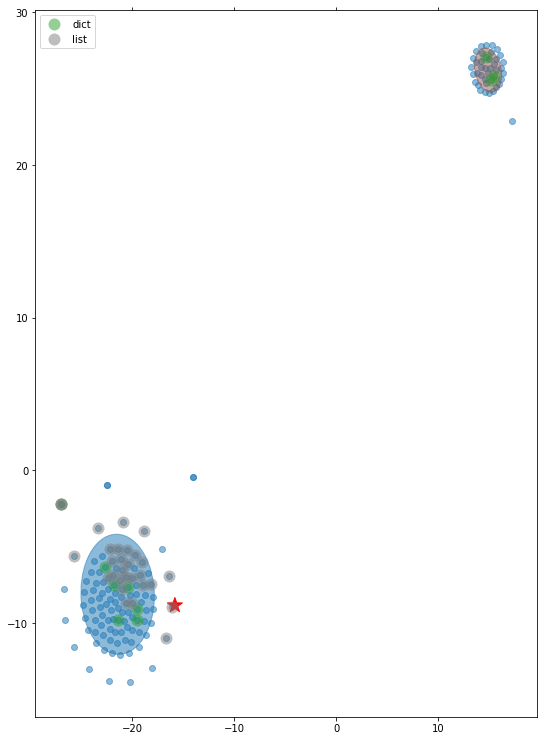

In [31]:
doc = PDFReport()
for i in range(25):
    # Plot sample
    sample_id, uRisks = get_next_sample(X, Y, W, L)
    
    ellipses_opt = {"gmm": clustering.model, "clusters": clustering.k}
    handler.plot(show_clusters=True, highlight=sample_id, show=False, savefig="solution_%d.png" % sample_id,
                make_ellipses=ellipses_opt)
    print("Question %d" % sample_id)
    
    # Print question
    problem = questions[sample_id]
    solution = solutions[sample_id]
    
    # Suppose that the student gets it correctly
    # Update X matrix
    X[sample_id] = Y[sample_id]
    L.append(sample_id)
    doc.append_solution(sample_id, problem, solution)

doc.generate_pdf("user_trajectory")

In [12]:

########################################################################
# Date: June 2015
# Author: Edward Johns (e.johns@imperial.ac.uk)
# This code may be freely distributed, but citations should be made to:
# E. Johns et al, "Becoming the Expert - Interactive Multi-Class Machine Teaching", in Proceedings of CVPR 2015
########################################################################

def get_next_sample(X, Y, W, L):

    # Based on "Zhu et al., Combining Active Learning and Semi-Supervised Learning Using Gaussian Fields and Harmonic Functions, in ICML workshop 2003"

    # Input:
    # Below, nS = total number of samples, nC = number of classes, nL = number of observed samples, nT = total number of testing samples to be shown to user
    # X: nS*nC belief matrix, with each row representing one sample, and each column representing one column. Each element is the probability that the user thinks that sample is assigned to that class. This would be identical to Y if we were assuming that the user always assigns the ground truth to an observed sample, and never has memory fall-off.
    # Y: nS*nC ground truth matrix (NumPy array), with each row in indicator encoding. This represents the ground-truth labels of all points. As such, each row has only one "1" and all other entries are "0".
    # W: nS*nS graph weights matrix (symmetrical NumPy array), with each row and each column corresponding to one sample. Each element is the weight (affinity) between two samples.
    # L: nL*1 labeled set, where each element is one sample that has already been shown to the user, with indices between 1 and nS.
    # Output:
    #    next_sample: the index of the optimum sample to be shown next, as selected by the active teaching algorithm.

    # Get the total number of samples (nS) and total number of classes (nC). nC is not actually used.
    [nS, nC] = X.shape

    # Create the set of unlabelled samples (U)
    U = np.setdiff1d(np.arange(nS), L)

    # Get the number of unlabelled samples (nU)
    nU = len(U)

    # Get the ground truth for the unlabelled samples
    Yu = Y.take(U, 0)

    # Get the unlabelled section of the covariance matrix
    Delta = np.subtract(np.diag(np.sum(W, 1)), W)
    ## To understand the take functions
    ## Delta.take(U,0) = Delta[U,:]
    ## Delta.take(U,1) = Delta[:,U]
    ## Delta.take(U, 0).take(U, 1) = Delta[U,:][:, U]
    ## It filters for every unlabeled row, the unlabeled columns.
    invDeltaU = np.linalg.inv(Delta.take(U, 0).take(U, 1))

    # Get the current state of the GRF, for the unlabeled samples
    ## W[U, :][:,L] = W.take(U, 0).take(L, 1)
    ## X[L, :] = X.take(L, 0)
    ## Why W and not Delta?? Delta is the negative of W for indices that are not ii.
    ## Not sure why original implementation chose W and not Delta
#     f = np.dot(invDeltaU, np.dot(W.take(U, 0).take(L, 1), X.take(L, 0)))
#     print(f)
    # Mean value of the unlabeled data points
    f = np.dot(-invDeltaU, np.dot(Delta.take(U, 0).take(L, 1), X.take(L, 0)))

    # Create a list of risks, one for each unlabelled sample
    uRisks = np.zeros(nU)

    # Try each unlabelled sample
    for u in range(nU):
        # Find the sample number (remember that U is just the list of unlabelled samples, not all the samples)
        s = U[u]

        # Calculate the new state of the GRF if this sample were to be revealed to the user (here, we assume 
        # that the user's belief of this sample will then be the ground truth -- debatable...)
        GG = invDeltaU[:, u] / invDeltaU[u, u]
        diff = Y[s, :] - f[u, :]
        fPlus = f + np.dot(GG[..., np.newaxis], diff[np.newaxis, ...])

        # Sum up the risks over all unlabelled points (i.e. the difference between the new state, and the 
        # ground truth)
#         D = np.abs(1 - fPlus[Yu == 1])
        # Don't understand why the need of ABS. Maybe because it was negative when using W and not Delta?
        D = 1 - fPlus[Yu == 1]
        uRisks[u] = np.sum(D)

    # Get the sample which minimised the risk
    next_sample_index = np.argmin(uRisks)
    next_sample = U[next_sample_index]

    # Return this sample
    return next_sample, uRisks

### References
[1] Johns, E., Aodha, O. Mac & Brostow, G. J. Becoming the expert - Interactive multi-class machine teaching. in Proceedings of the IEEE Computer Society Conference on Computer Vision and Pattern Recognition (2015). doi:10.1109/CVPR.2015.7298877

[2] Zhu, X., Lafferty, J. & Ghahramani, Z. Combining Active Learning and Semi-Supervised Learning Using Gaussian Fields and Harmonic Functions Xiaojin. … Data Mach. Learn. … (2003).